# Hybrid method to solve for Black-Scholes PDE

Black-Scholes posits that stock shares will have a lognormal distribution of prices following a random walk with constant drift and volatility. Using this assumption and factoring in other important variables, the equation derives the price of a European-style call option. (https://www.investopedia.com/terms/b/blackscholes.asp#:~:text=The%20Black%2DScholes%20model%2C%20aka,free%20rate%2C%20and%20the%20volatility.)

I'll be solving this PDE with two methods: using Finite Differences to discretize the equation in the space domain and Runge Kutta to solve for each time step within a given time interval

\begin{equation}
    \frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S\frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
\end{equation}

- $S$ is Stock Price
- $V$ is European Option Price (both call or put)
- $t$ is Option's time to Maturity
- $\sigma$ is Volatility of the Asset
- $r$ is Risk-Free Interest Rate

An option can either be a call or a put, our choice would change the boundary conditions. In this example, we'll be looking at the boundary conditions of the call option

### Call Option

- Non-Homogeneous Boundary Conditions

$$ V(S=0,t) = 0 $$ 
$$ V(S_{max},t) = S_{max} - Ke^{-r(T-t)} $$
$$ V(S,T) = max(S-K, 0) $$

### Selecting the Boundary Function

In order to solve for non-homogeneous boundaries, we'll need to define a function that has values at the boundaries. Using this function, we can change our problem back to a homogeneous Dirichlet problem. Setting Dirichlet boundaries conditions makes solving this PDE easier since we already have the matrices expression for such conditions

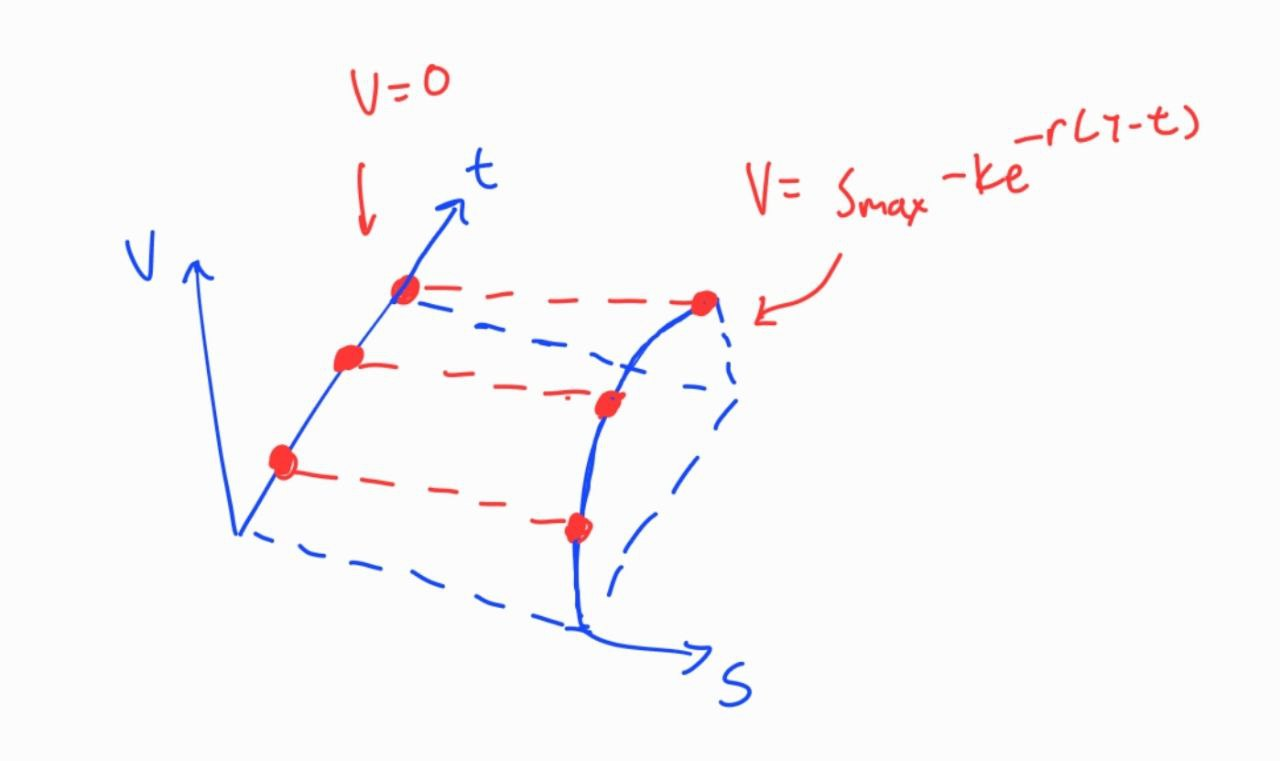

We choose a boundary function which consists of a series of lines seen in the image in red which passes through the points where $V(S=0) = 0$ and $V(S_{max}) = 0$ along any time t. After working through an analytical solution, we arrive at an expression of $U(t,S)$:

\begin{equation}
    U = 1 - \frac{K}{S_{max}}e^{-r(T-t)}(S)
\end{equation}

Next with the expression of the boundary function, we can define a new function $W(t,S) = V(t,S) - U(t,S)$ which satisfies the Dirichlet boundary conditions, 

\begin{align}
    W(S=0,t) &= 0\\
    W(S_{max},t) &= 0\\
    W(S,T) &= max(S-K, 0) - U(t,S)\\
\end{align}

After substituting $V(t,S)$ with $W(t,S) + U(t,S)$, the PDE can be re-written to:

\begin{equation}
    \frac{\partial W}{\partial t} + \frac{1}{2}\sigma^2 S\frac{\partial^2 W}{\partial S^2} + rS\frac{\partial W}{\partial S} - rW = -\frac{K}{S_{max}}(S)re^{-r(T-t)}
\end{equation}

We'll then proceed to use both Finite Differences and Runge Kutta to solve for $W(t,S)$ numnerically. After which we can use $ W = V - U \longrightarrow V = W + U$ to solve for $V(t,S)$ from our information of both $W$ and $U$

### Finite Differences to discretize along S

- Re-expressing the Black-Scholes PDE

$$ \frac{\partial W}{\partial t} + \frac{1}{2}\sigma^2S^2 \frac{W_{n+1} - 2W_n + W_{n-1}}{h^2} - rW_{n} + rS\frac{W_{n+1} - W_{n-1}}{2 h}  = \dots $$

$$\frac{\partial W}{\partial t} = \begin{bmatrix} \ddots & \ddots \\ \ddots & \frac{1}{h^2}\sigma^2S^2 +r & -\frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}+\frac{rS}{h}\!\!\right)\\ & -\frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}-\frac{rS}{h}\!\!\right) & \frac{1}{h^2}\sigma^2S^2 +r & -\frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}+\frac{rS}{h}\!\!\right)\\ & & -\frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}-\frac{rS}{h}\!\!\right) & \frac{1}{h^2}\sigma^2S^2 +r & \ddots \\ & & & \ddots & \ddots & \end{bmatrix} \begin{bmatrix}\vdots \\ W_{n-1} \\ W_n \\ W_{n+1} \\ \vdots\end{bmatrix} + \dots$$

- With Dirichlet Boundary Conditions along S, 

$$\frac{\partial W}{\partial t} =\begin{bmatrix} \frac{1}{h^2}\sigma^2S^2 -r & -\frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}+\frac{rS}{h}\!\!\right) & \\ -\frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}-\frac{rS}{h}\!\!\right) & \frac{1}{h^2}\sigma^2S^2 -r & \ddots & \\ & \ddots & \ddots & -\frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}+\frac{rS}{h}\!\!\right) \\ & & -\frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}-\frac{rS}{h}\!\!\right) & \frac{1}{h^2}\sigma^2S^2 -r\end{bmatrix}\begin{bmatrix} W_{0} \\ W_{1} \\ \dots \\ W_{N-1}\end{bmatrix} + \dots$$

### Obtaining the Discretized Matrix

In [2]:
import numpy as np

#inputs

sigma = 0.1 #volatility
r = 0.035 #risk-free interest rate
K = 50 #strike price

Smin = 0.; Smax = 100.; 
tmin = 0.; tmax = 1.
nGridPoints = 50

In [3]:
## Construction of the grid
SFullGrid = np.linspace(Smin,Smax,nGridPoints+2) # Full discretisation grid
SGrid = SFullGrid[1:-1]                          # Discretisation grid excluding one boundary
h = SFullGrid[1]-SFullGrid[0]                    # Step size

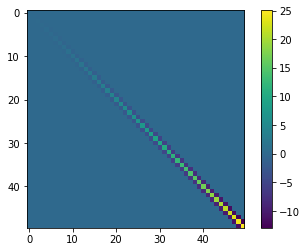

In [4]:
import matplotlib.pyplot as plt

Diag = np.diag(np.ones(nGridPoints))
offDiag1 = np.diag(np.ones(nGridPoints-1),+1)
offDiag2 = np.diag(np.ones(nGridPoints-1),-1)

BlackSchMatr = (((sigma**2*SGrid**2)/(h**2))+r) * Diag
BlackSchMatr += -((0.5*((sigma**2*SGrid**2)/(h**2) + (r*SGrid)/(2*h)))) * offDiag1
BlackSchMatr += -((0.5*((sigma**2*SGrid**2)/(h**2) - (r*SGrid)/(2*h)))) * offDiag2

plt.imshow(BlackSchMatr)
plt.colorbar()

### Using Runge Kutta at each time step to solve for W

$$\frac{\partial}{\partial t}\begin{bmatrix} W_{0} \\ W_{1} \\ \dots \\ W_{N-1}\end{bmatrix} =\begin{bmatrix} \frac{1}{2h^2}\sigma^2S^2 -r & \frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}+\frac{rS}{h}\!\!\right) & \\ \frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}-\frac{rS}{h}\!\!\right) & \frac{1}{2h^2}\sigma^2S^2 -r & \ddots & \\ & \ddots & \ddots & \frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}+\frac{rS}{h}\!\!\right) \\ & & \frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}-\frac{rS}{h}\!\!\right) & \frac{1}{2h^2}\sigma^2S^2 -r\end{bmatrix}\begin{bmatrix} W_{0} \\ W_{1} \\ \dots \\ W_{N-1}\end{bmatrix} + \dots$$

In [5]:
def rungeKutta4(operator, initCond, initTime, finalTime, nSteps):
    ''' 
    Solves an ODE of type dy(t)/dt = f(t,y(t)) using Runge Kutta 4
    
    Parameters
        ----------
        operator  : function
            function of time (: float) and the y (: float / numpy.array)
            NOTICE: it must a function of both variables even if not explicitly dependent on both
            For instance:   lambda t, y: np.sin(y)    and not     lambda y: np.sin(y) 
        initCond  : float / numpy.array
            initial condition, i.e. y(t = initial time)
        initTime  : float
            initial time
        finalTime : float
            final time of the simulation
        nSteps    : int
            number of steps to take
        
    Returns
        ----------
        times : numpy.array
            numpy array of all the calculated times
        solution : numpy.array
            numpy array of all the calculated y's
    '''
    
    dt = (finalTime - initTime)/nSteps
    times = np.linspace(initTime, finalTime, nSteps+1)
    solut = [initCond]
    
    for t in times[:-1]:
        k1 = dt * operator(t, solut[-1])
        k2 = dt * operator(t + dt/2, solut[-1]+ k1/2 )
        k3 = dt * operator(t + dt/2, solut[-1] + k2/2 )
        k4 = dt * operator(t + dt, solut[-1] + k3)
        solut.append(solut[-1] + (k1 + 2*k2 + 2*k3 + k4)/6)
        
    return times, np.array(solut)

- Expressing the function at the boundaries 

In [6]:
boundFunc = lambda t, S: (1 - (K/Smax)*np.exp(-r*(1-t)))*S

- Defining the Ramp function as the initial condition: 

$$W(S,T) = max(S-K, 0) - U(t,S)$$

- a particular $V$ has the value of $(S-K)$ when $(S-K)$ is is more than 0

In [7]:
def ramp(Grid, strikePrice):
    rampVec = []
    for pts in Grid:
        if pts - strikePrice <= 0:
            rampVec.append(-boundFunc(1,pts)) 
            #append only the boundary function when S-K < 0
            
        else:
            rampVec.append((pts-strikePrice) - boundFunc(1,pts)) 
            #append both the value of S-K and the boundary function when S-K >0
            
    return np.array(rampVec)

initCond = ramp(SGrid, K)

- Now can put together both the discretized matrix and the function $\frac{K}{S_{max}}(S)re^{-r(T-t)}$

\begin{equation}
    \frac{\partial}{\partial t}\begin{bmatrix} W_{0} \\ W_{1} \\ \dots \\ W_{N-1}\end{bmatrix} =\begin{bmatrix} \frac{1}{2h^2}\sigma^2S^2 -r & \frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}+\frac{rS}{h}\!\!\right) & \\ \frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}-\frac{rS}{h}\!\!\right) & \frac{1}{2h^2}\sigma^2S^2 -r & \ddots & \\ & \ddots & \ddots & \frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}+\frac{rS}{h}\!\!\right) \\ & & \frac{1}{2}\left(\!\!\frac{\sigma^2S^2}{h^2}-\frac{rS}{h}\!\!\right) & \frac{1}{2h^2}\sigma^2S^2 -r\end{bmatrix}\begin{bmatrix} W_{0} \\ W_{1} \\ \dots \\ W_{N-1}\end{bmatrix} -\frac{K}{S_{max}}(S)re^{-r(T-t)}
\end{equation}

In [8]:
coeff = lambda S: (K/(Smax-K))*S #Coefficient of the function
coeffVec = coeff(SGrid)

Oper = lambda t, V: np.dot(BlackSchMatr, V) - coeffVec*r*np.exp(-r*(tmax-t))
times, sol = rungeKutta4(Oper, initCond, 1, 0, 50) #Initial time, 1s due to boundary conditions

- Finally, since we've obtained the numerical solution for $W$ instead of $V$, we can obtain $V$ from adding the boundary function back in where $ W = V - U \longrightarrow V = W + U$

In [9]:
boundArr = []
for time in times: 
    boundArr.append(boundFunc(time, SGrid)) #boundary function at all times 

boundArr = np.array(boundArr)
newSoln = sol + boundArr #new solution: addition of the numerical solution with the boundary function

### Final Thoughts

Finally, our solution is similar to the one found in (https://towardsdatascience.com/option-pricing-using-the-black-scholes-model-without-the-formula-e5c002771e2f) along with mostly the same parameters . However, changing certain input values does change the look of what we obtained drastically. Firstly, it's important to keep volatility, $\sigma$ low since increasing it to more than 0.1 affects the validatity of our solution. The more volatile the markets, the less effective the Black-Scholes model. Secondly, it's vital to keep the time interval, $t_{max} - t_{min} $ short, with anything more than one second drastically changing the look of our solution

- Solution displayed here moving backwards in time from T=tmax(1s) to T=0

In [10]:
import matplotlib.pyplot as plt

## Enable HTML5 video output.
from matplotlib import animation, rc
rc('animation', html='html5')
     
def animate_oscillation():

    ## Set up the drawing area
    fig = plt.figure(figsize=(8,4))
    plt.xlim(Smin,Smax)
    plt.ylim(0,60)
    
    ## Draw the static parts of the figure
    plt.xlabel('S'); plt.ylabel('V');

    ## Initialize the plot objects to be animated (`line', `circ', `dash')
    ## with empty plot data.  They'll be used by the `animate` subroutine.
    stringDots, = plt.plot([], [], 'o', color='black', markersize=5)
    string,  = plt.plot([], [], color='black', linewidth=2)
    plt.close()
    
    numFrames = 50
    totalSteps = len(times)
    stepsAtFrame = int(totalSteps/numFrames)
    
    ## Initialization function: plot the background of each frame
    def init():
        stringDots.set_data([], [])
        string.set_data([], [])
        return stringDots, string

    ## Animation function. This is called sequentially for different
    ## integer n, running from 0 to nframes-1 (inclusive).
    def animate(n):
        index = int(stepsAtFrame*n)
        dataset = np.concatenate((np.concatenate((np.array([0.]),newSoln[index,:nGridPoints])),np.array([0.])))
        stringDots.set_data(SFullGrid,dataset)
        string.set_data(SFullGrid,dataset)        
        return stringDots, string

    # Call the animator. blit=True means only re-draw the parts that have changed.
    animator = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=numFrames, interval=100, blit=True)
    return animator

animate_oscillation()